## Assign species, location and date information to each contig

In [1]:
import glob,os
from datetime import datetime as dt

import glob,os
import treetime
import importlib.machinery
import importlib.util
loader = importlib.machinery.SourceFileLoader('baltic','/Users/evogytis/Documents/baltic/baltic.py')
spec = importlib.util.spec_from_loader(loader.name, loader)
bt = importlib.util.module_from_spec(spec)
loader.exec_module(bt)


base_path='/Users/evogytis/Documents/manuscripts/skeeters/'

meta_path=os.path.join(base_path,'data/metadata/CMS001_CMS002_MergedAnnotations.csv')
metadata={}

for line in open(meta_path,'r'):
    l=line.strip('\r\n').split(',')
    if 'NewIDseqName' in l[0]:
        header=l
        print(header)
    else:
        metadata[l[0]]={header[i]:l[i].strip(' ') for i in range(len(l))} ## load metadata


for fname in glob.glob(os.path.join(base_path,'sequences/fig6_WMV6/Wuhan_mosquito_virus_6_*.fasta')): ## iterate over alignments
    if 'dated' not in fname:
        print(os.path.basename(fname))
        out=open(fname.replace('.fasta','.dated.fasta'),'w') ## open fasta
        
        for line in open(fname,'r'):
            l=line.strip('\n').replace('_(reversed)','') ## remove Geneious annotations for reverse complemented contigs
            if '>' in l:
                name=None
                if '>CMS' in l:
                    sample,contig=l[1:].split('|') ## get sample and contig
                    genus=metadata[sample]['ska_genus'] ## fetch sample's genus
                    species=metadata[sample]['ska_species'] ## fetch sample's species
                    spp='%s_%s'%(genus,species) ## form species string

                    date=metadata[sample]['collection_date'] ## get collection date
                    
                    dt_date=dt.strptime(date,"%m/%d/%y") if date!='NA' else None ## datetime object for date
                    fmt_date=dt.strftime(dt_date,'%Y-%m-%d') if dt_date is not None else 'NA' ## format date string

                    loc=metadata[sample]['collected_by'] ## get collection location
                    if date!='NA': ## only interested in sequences that had a date
                        name='>%s'%('|'.join([sample,spp,loc,fmt_date])) ## set sequence name
            else:
                seq=l
                if name: ## if sequence had a date
                    out.write('%s\n%s\n'%(name,seq)) ## output to file
        out.close()

['NewIDseqName', 'OldIDseqName', 'czbiohub-mosquito_sequences_id', 'host', 'sample_type', 'nucleotide_type', 'collection_date', 'collection_lat', 'collection_long', 'Habitat', 'Population', 'collected_by', 'preservation_method', 'sex', 'life_stage', 'visual_genus', 'visual_species', 'sourmash_genus', 'sourmash_species', 'ska_genus', 'ska_species', 'blood_fed', 'sample_unit', 'known_organism', 'detection_method', 'library_prep', 'sequencer', 'rna_dna_input_ng', 'library_prep_batch', 'extraction_batch', 'Notes:', 'Genus_test', 'Species_test', 'read1', 'read2', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Wuhan_mosquito_virus_6_NP.fasta
Wuhan_mosquito_virus_6_hypothetical.fasta
Wuhan_mosquito_virus_6_hypothetical3e.fasta
Wuhan_mosquito_virus_6_PA.fasta
Wuhan_mosquito_virus_6_PB1.fasta
Wuhan_mosquito_virus_6_gp64.fasta
Wuhan_mosquito_virus_6_PB2.fasta
Wuhan_mosquito_virus_6_hypothetical2.fasta


## Root ML phylogenies with treetime root-to-tip regression

In [2]:
for tfile in glob.glob(os.path.join(base_path,'data/trees/fig6_WMV6/ML/*.newick')):
    if 'rooted' not in tfile:
        print(tfile)
        tree_path=tfile

        ll=bt.loadNewick(tree_path)

        ll.treeStats()
        tip_dates={k.numName:bt.decimalDate(k.numName.split('|')[-1],variable=True) for k in ll.getExternal()}

        tt = treetime.TreeTime(dates=tip_dates, tree=tree_path) ## load tree
        new_root=tt.reroot('best') ## reroot
        treetime.treetime.treetime_to_newick(tt,tree_path.replace('.newick','.rooted.newick')) ## save tree

/Users/evogytis/Documents/manuscripts/skeeters/data/trees/fig6_WMV6/ML/PB2.newick

Tree height: 0.024011
Tree length: 0.067097
strictly bifurcating tree

Numbers of objects in tree: 39 (19 nodes and 20 leaves)


0.00	-TreeAnc: set-up
0.01	--ClockTree: Setting precision to level 2

0.01	TreeTime.reroot: with method or node: least-squares

0.01	TreeTime.reroot: rerooting will ignore covariance and shared ancestry.
0.01	--TreeTime._find_best_root: searching for the best root position...
0.16	--TreeTime.reroot: Tree was re-rooted to node NODE_0000007
0.26	--ClockTree.date2dist: Setting new molecular clock. rate=5.750e-04, R^2=0.4315
/Users/evogytis/Documents/manuscripts/skeeters/data/trees/fig6_WMV6/ML/hypothetical2.newick

Tree height: 0.021806
Tree length: 0.046203
strictly bifurcating tree

Numbers of objects in tree: 39 (19 nodes and 20 leaves)


0.00	-TreeAnc: set-up
0.01	--ClockTree: Setting precision to level 2

0.02	TreeTime.reroot: with method or node: least-squares

0.03	TreeTime

## Load necessary libraries, map of California

In [3]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec

typeface='Helvetica Neue'
# mpl.rcParams['font.weight']=400
mpl.rcParams['mathtext.fontset']='custom'
mpl.rcParams['font.sans-serif']=typeface
mpl.rcParams['mathtext.default']='sf'
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

import requests,json,imp,copy
from io import StringIO
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np

# bt=imp.load_source("baltic","/Users/evogytis/Documents/baltic/baltic.py")

meta_path=os.path.join(base_path,'data/metadata/CMS001_CMS002_MergedAnnotations.csv')
metadata={}

sample_colour={'ALCO':(0.49803923567136127, 0.43267975250879925, 0.52287583549817396), ## purple
               'WVAL':(0.88366013765335083, 0.77908497055371606, 0.18562091886997223), ## yellow
               'COAV':(0.8162552973803352, 0.41062668737243202, 0.29078047883276847), ## red
               'PLCR':(0.28098424626331703, 0.63955403192370541, 0.39507882933990629), ## green
               'SAND':(0.4666666666666667, 0.7450980392156863, 0.8588235294117647), ## light blue
               'NA':  '#C0C0C0'}

rename={'PLCR':'Placerville', 
        'ALCO': 'Alameda County', 
        'WVAL': 'West Valley', 
        'COAV': 'Coachella Valley', 
        'SAND': 'San Diego'}

for line in open(meta_path,'r'):
    l=line.strip('\r\n').split(',')
    if 'NewIDseqName' in l[0]:
        header=l
        print(header)
    else:
        metadata[l[0]]={header[i]:l[i].strip(' ') for i in range(len(l))}

California_counties_url='https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/california-counties.geojson'
response=requests.get(California_counties_url)

json_map=json.load(StringIO(response.text)) ## import json

features=json_map['features']
location_points={} ## location points will be stored here
polygons={} ## polygons will be stored here

locName='name' ## key name for each feature

for loc in features: ## iterate through features (locations)
    poly = np.asarray(loc['geometry']['coordinates']) ## get coordinates
    location=loc['properties'][locName]
    polygons[location]=[]
    location_points[location]=[]
    if loc['geometry']['type']=='MultiPolygon': ## multiple parts detected
        for part in np.asarray(poly): ## iterate over each component polygon
            for coords in np.asarray(part): ## iterate over coordinates
                coords=np.array(coords)
                xs=coords[:,0] ## longitudes
                ys=coords[:,1] ## latitudes

                location_points[location].append(np.vstack(zip(xs,ys))) ## append coordinates to location's list of coordinates
    if loc['geometry']['type']=='Polygon': ## location is single part
        for coords in np.asarray(poly): ## iterate over coordinates
            coords=np.array(coords)
            xs=coords[:,0] ## longitudes
            ys=coords[:,1] ## latitudes
            location_points[location].append(np.vstack(zip(xs,ys))) ## append coordinates to location's list of coordinates

    complete_location=[]
    for part in location_points[location]: ## iterate over each component of a location
        complete_location.append(Polygon(part,True)) ## create a polygon for each component of a location

    polygons[location]=complete_location ## assign list of polygons to a location

['NewIDseqName', 'OldIDseqName', 'czbiohub-mosquito_sequences_id', 'host', 'sample_type', 'nucleotide_type', 'collection_date', 'collection_lat', 'collection_long', 'Habitat', 'Population', 'collected_by', 'preservation_method', 'sex', 'life_stage', 'visual_genus', 'visual_species', 'sourmash_genus', 'sourmash_species', 'ska_genus', 'ska_species', 'blood_fed', 'sample_unit', 'known_organism', 'detection_method', 'library_prep', 'sequencer', 'rna_dna_input_ng', 'library_prep_batch', 'extraction_batch', 'Notes:', 'Genus_test', 'Species_test', 'read1', 'read2', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:70: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:76: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


In [4]:
seg_order=['PB2','PB1','PA','NP','gp64','hypothetical','hypothetical2','hypothetical3']

trees={}
for tfile in glob.glob(os.path.join(base_path,'data/trees/fig6_WMV6/ML/*.rooted.newick')):
    if 'rooted' in tfile:
        seg=os.path.basename(tfile).split('.')[0]
        print(seg)
        ll=bt.loadNewick(tfile)
        ll.tipMap={k.numName: k.numName for k in ll.getExternal()}
        for k in ll.getExternal():
            k.name=k.numName
        trees[seg]=ll.collapseBranches(collapseIf=lambda k:k.length==0.0)
        trees[seg].treeStats()
        
tip_positions={x:{} for x in trees} ## remember the position of each tip in each tree

for t,tr in enumerate(trees.keys()): ## iterate over trees
    cur_tree=trees[tr] ## fetch tree object
    for k in cur_tree.Objects:
        if k.branchType=='leaf':
            tip_positions[tr][k.numName]=(k.height,k.y) ## remember (X, Y) position of tip

cmap=mpl.cm.Spectral

segments=['PB2','PB1','PA','NP','gp64','hypothetical','hypothetical2','hypothetical3']
print(trees.keys())

for X in range(10): ## 10 untangling iterations
    print('iteration %d'%(X+1))
    for t,tr in enumerate(segments): ## iterate over each tree
        print(tr)
        ptr=segments[t-1] ## previous tree
        ntr=segments[t] ## next tree
        seg=trees[ptr] ## fetch appropriate tree
        nex_seg=trees[ntr]
        for k in sorted(nex_seg.Objects,key=lambda q:q.height): ## iterate over branches from most recent to oldest
            if k.branchType=='node': ## can only sort nodes
                leaves=[[seg.tipMap[tip] for tip in w.leaves if tip in seg.tipMap] if w.branchType=='node' else [w.name] for w in k.children] ## descendent tips in current order

                for c in range(len(leaves)):
                    leaves[c]=sorted(leaves[c],key=lambda x:tip_positions[ntr][x][1] if x in tip_positions[ntr] else 0.0) ## sort leaves according to their positions in the next tree
                
                ys=[sorted([tip_positions[ntr][w][1] for w in cl if w in tip_positions[ntr]]) for cl in leaves] ## extract y positions of descendents
                merge_ys=sum(ys,[]) ## flatten list of tip y coordinates
                ypos=sorted(merge_ys) ## get y positions of tips in current order
                
                order={i:x for i,x in enumerate(leaves)} ## dict of tip order: tip name
                
                new_order=sorted(order.keys(),key=lambda x:-np.mean([(tip_positions[ptr][order[x][w]][1]-ypos[w]) for w in range(min([len(order[x]),len(ypos)])) if order[x][w] in tip_positions[ptr]])) ## get new order by sorting existing order based on y position differences
                
                if new_order!=range(len(leaves)): ## if new order is not current order
                    k.children=[k.children[i] for i in new_order] ## assign new order of child branches
                    nex_seg.drawTree() ## update y positions

                    for w in nex_seg.Objects: ## iterate over objects in next tree
                        if w.branchType=='leaf':
                            tip_positions[ntr][w.name]=(w.height,w.y) ## remember new positions
                
        if t==0: ## if first tree
            trees[segments[t]].drawTree() ## update positions
            lvs=sorted([w for w in trees[segments[t]].Objects if w.branchType=='leaf'],key=lambda x:x.y) ## get leaves in y position order
            

gp64

Tree height: 0.031690
Tree length: 0.073180
annotations present

Numbers of objects in tree: 27 (7 nodes and 20 leaves)

PB1

Tree height: 0.022280
Tree length: 0.068180
annotations present

Numbers of objects in tree: 33 (13 nodes and 20 leaves)

PB2

Tree height: 0.018980
Tree length: 0.068080
annotations present

Numbers of objects in tree: 33 (13 nodes and 20 leaves)

hypothetical

Tree height: 0.009830
Tree length: 0.029620
annotations present

Numbers of objects in tree: 28 (8 nodes and 20 leaves)

hypothetical2

Tree height: 0.022810
Tree length: 0.047210
annotations present

Numbers of objects in tree: 25 (5 nodes and 20 leaves)

NP

Tree height: 0.017760
Tree length: 0.046370
annotations present

Numbers of objects in tree: 30 (10 nodes and 20 leaves)

hypothetical3

Tree height: 0.029380
Tree length: 0.077800
annotations present

Numbers of objects in tree: 28 (8 nodes and 20 leaves)

PA

Tree height: 0.023500
Tree length: 0.080060
annotations present

Numbers of object


Tree height: 8.436595
Tree length: 28.937328
multitype tree
annotations present

Numbers of objects in tree: 75 (43 nodes and 32 leaves)


Tree height: 8.436595
Tree length: 23.745521
strictly bifurcating tree
annotations present

Numbers of objects in tree: 51 (25 nodes and 26 leaves)

lower: 2006.79 
mean: 2009.47 
upper: 2010.76 
min tree height: 11.12 
mean tree height: 8.44 
max tree height: 7.14


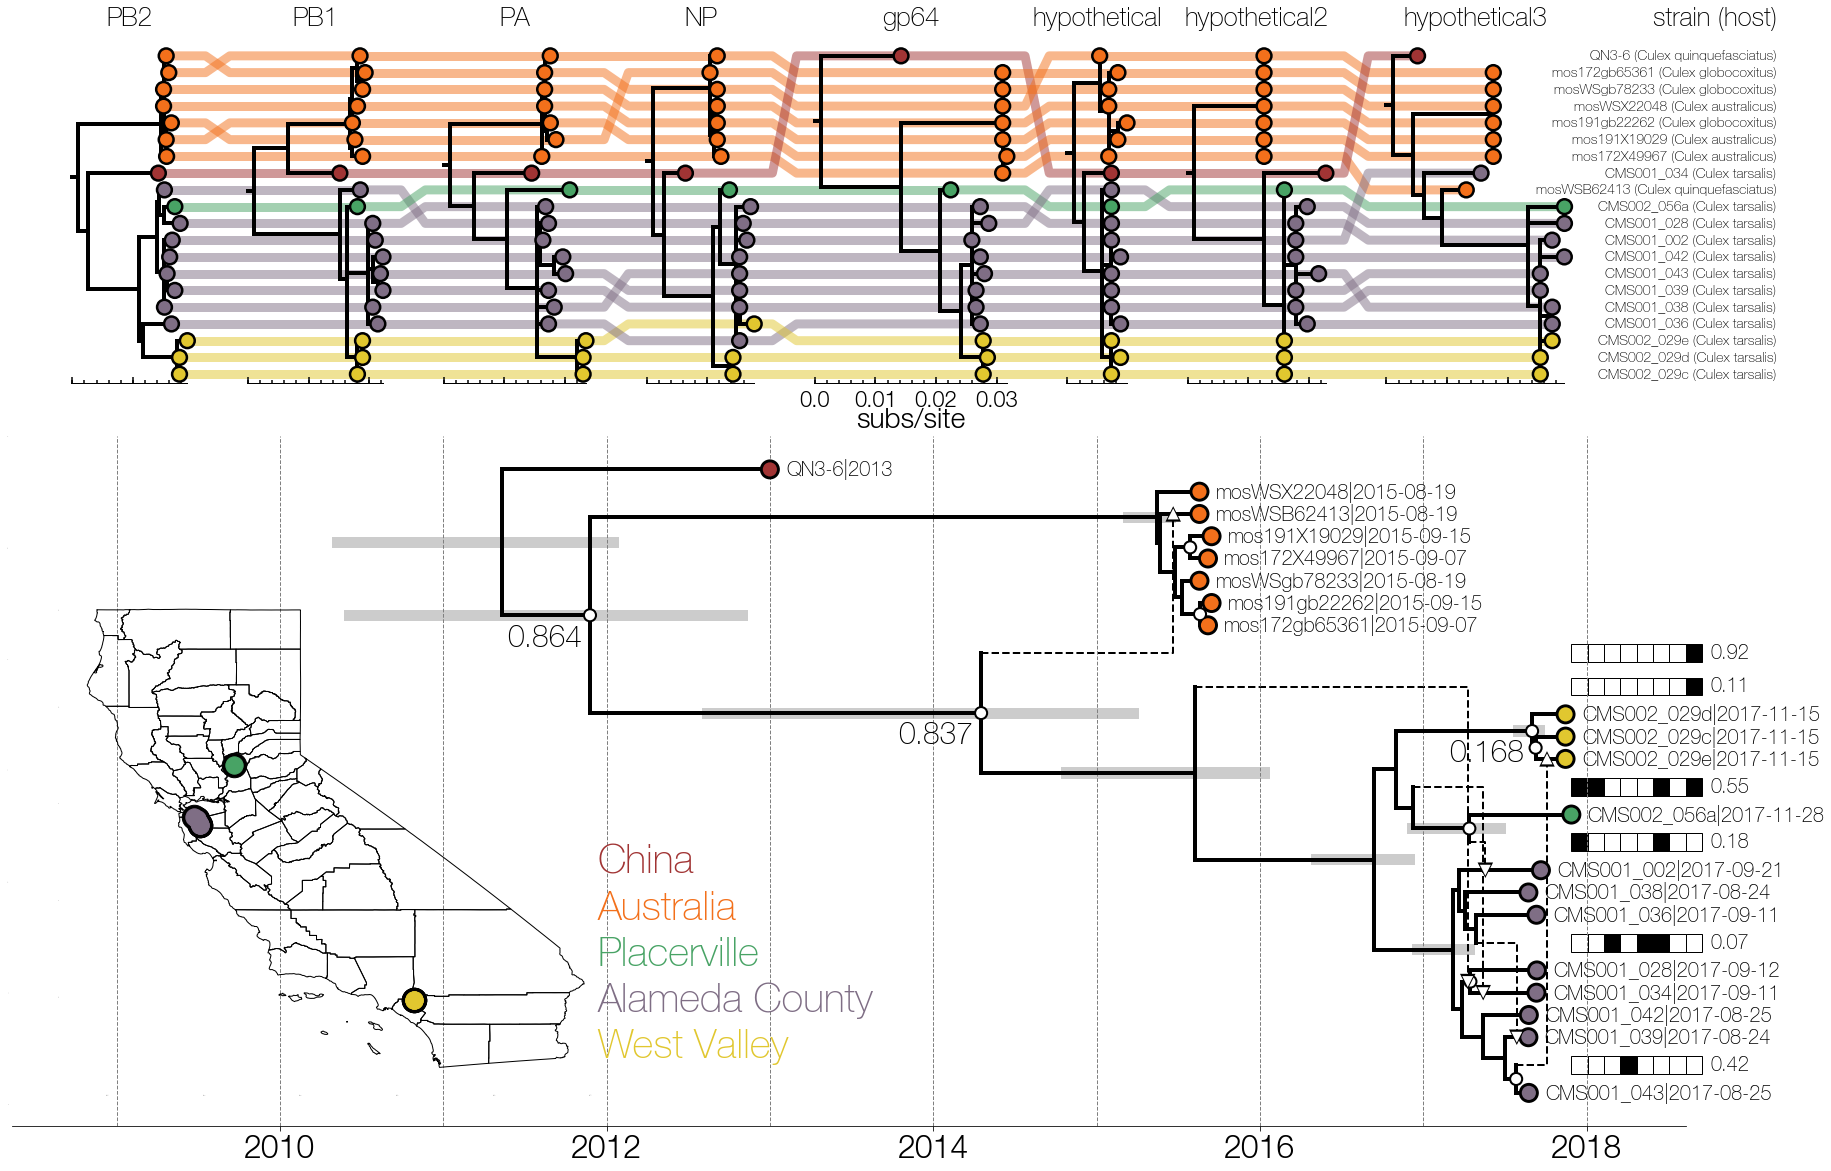

In [5]:
fig = plt.figure(figsize=(30, 20),facecolor='w') 
gs = gridspec.GridSpec(2,1,height_ratios=[1,2],wspace=0.01,hspace=0.1) 

ax=plt.subplot(gs[0],facecolor='w')
ax1=plt.subplot(gs[1],facecolor='w')

cumulative_displace=0 ## this tracks the "current" x position, so trees are plotted one after another

contigs=lambda k: k.branchType=='leaf' and 'CMS' in k.name
sampleID=lambda k: k.name.split('|')[0] if isinstance(k,bt.leaf) else k.split('|')[0]

meta_geo_lat=lambda k: float(metadata[sampleID(k)]['collection_lat']) if metadata[sampleID(k)]['collection_lat']!='NA' else None
meta_geo_lon=lambda k: float(metadata[sampleID(k)]['collection_long']) if metadata[sampleID(k)]['collection_long']!='NA' else None

lats=list(map(float,filter(None,map(meta_geo_lat,ll.getBranches(contigs)))))
lons=list(map(float,filter(None,map(meta_geo_lon,ll.getBranches(contigs)))))

norm_lat=mpl.colors.Normalize(vmin=min(lats),vmax=max(lats))
norm_lon=mpl.colors.Normalize(vmin=min(lons),vmax=max(lons))

tip_groups={}
tip_colours={}
for k in trees['PB1'].getExternal():
    if 'QN' in k.name:
        tip_groups[k.name]='china'
        tip_colours[k.name]='#A13434'
    elif 'CMS' in k.name:
        tip_groups[k.name]=metadata[sampleID(k.name)]['collected_by']
    else:
        tip_groups[k.name]='australia'
        
for g,group in enumerate(['WVAL','ALCO','PLCR','australia','china']):
    members=[k for k in tip_groups if tip_groups[k]==group]
    for t,tip in enumerate(sorted(members,key=lambda w: tip_positions['PB1'][w][1])):
        shift=1
        if group=='australia':
            cmap=mpl.cm.Oranges
            frac=0.6
            tip_colours[tip]=cmap(frac)
            
        elif group!='china':
            tip_colours[tip]=sample_colour[metadata[sampleID(tip)]['collected_by']]
            
    if group.capitalize() in ['China','Australia']:
        group=group.capitalize()
    else:
        group=group.upper()
        
    if group in rename:
        group=rename[group]
        
    ax1.text(0.35,0.10+g/15.0,group,size=40,
             color=tip_colours[members[0]],transform=ax1.transAxes,zorder=100) ## add legend text

subax = fig.add_axes([0.1,0.15,0.35,0.35],facecolor='none',zorder=0)
subax.set_aspect(1)
subax.tick_params(size=0,labelsize=0)
[subax.spines[side].set_visible(False) for side in subax.spines]

for loc in polygons:
    county=PatchCollection(polygons[loc],facecolor='none',edgecolor='k',zorder=0)
    subax.add_collection(county) ## add county polygons to map
subax.plot()

for k in cur_tree.getBranches(contigs):
    if meta_geo_lat(k):
        colour=sample_colour[metadata[sampleID(k.name)]['collected_by']]
        subax.scatter(meta_geo_lon(k),meta_geo_lat(k),s=300,
                      facecolor=colour,zorder=100)
        subax.scatter(meta_geo_lon(k),meta_geo_lat(k),s=600,facecolor='k',zorder=99) ## add circles to map


tree_names=['PB2','PB1','PA','NP','gp64','hypothetical','hypothetical2','hypothetical3']
xml_segment_order=['NP', 'PA', 'PB1', 'PB2', 'gp64', 'hypothetical2', 'hypothetical3', 'hypothetical'] ## order in which segments appear in XML


displaceAmount=0.01 ## space between trees

for t,tr in enumerate(tree_names): ## iterate over trees
    cur_tree=trees[tr] ## fetch tree object
    x_attr=lambda k: k.height+cumulative_displace
    
    b_func=lambda k: 4
    cn_func=lambda k: 'k'
    
    cur_tree.plotTree(ax,x_attr=x_attr,branchWidth=b_func,colour_function=cn_func) ## plot tree
    
    for k in cur_tree.getExternal(): ## iterate over branches
        y=k.y

        colour=tip_colours[k.name]
        if 'CMS' in k.name:
            colour=sample_colour[metadata[sampleID(k.name)]['collected_by']]
        ax.scatter(x_attr(k),y,s=150,facecolor=colour,edgecolor='none',zorder=100)
        ax.scatter(x_attr(k),y,s=300,facecolor='k',edgecolor='none',zorder=99)
        
        if t!=len(tree_names)-1: ## as long as we're not at the last tree - connect tips with coloured lines
            if k.name in tip_positions[tree_names[t+1]]:
                next_x,next_y=tip_positions[tree_names[t+1]][k.name] ## fetch coordinates of same tip in next tree
                next_x+=cumulative_displace+cur_tree.treeHeight+displaceAmount ## adjust x coordinate by current displacement and future displacement
                nextIncrement=cumulative_displace+cur_tree.treeHeight
                
                step1=(x_attr(k),y)
                step2=(nextIncrement+0.3*displaceAmount,y)
                step3=(nextIncrement+0.7*displaceAmount,next_y)
                step4=(next_x,next_y)
                
                xs,ys=zip(*(step1,step2,step3,step4))
                
                ax.plot(xs,ys,lw=9,ls='-',color=colour,zorder=0,alpha=0.5,solid_capstyle='round') ## connect current tip with same tip in the next tree
                
    ax.text(cumulative_displace+cur_tree.treeHeight/2,max([T.ySpan for T in trees.values()])+1,tr,size=26,va='bottom',ha='center')
    
    ax.eventplot(np.arange(cumulative_displace,cumulative_displace+cur_tree.treeHeight,2e-3),
                 linelengths=1.0,colors=['k'],lineoffsets=[-0.35])
    ax.eventplot(np.arange(cumulative_displace,cumulative_displace+cur_tree.treeHeight,1e-2),
                 linelengths=1.6,colors=['k'],lineoffsets=[-0.46])
    ax.plot([cumulative_displace,cumulative_displace+cur_tree.treeHeight],[-0.1,-0.1],lw=2,color='k')
    
    if tr=='gp64':
        for t in np.arange(0,cur_tree.treeHeight,1e-2):
            ax.text(cumulative_displace+t,-0.5,'%s'%(t),size=22,va='top',ha='center',weight=300,clip_on=False)
        ax.text(cumulative_displace+cur_tree.treeHeight/2.0,-1.5,'subs/site',
                size=28,va='top',ha='center',weight=300,clip_on=False)
    
    cumulative_displace+=cur_tree.treeHeight+displaceAmount ## increment displacement by the height of the tree

offsetLabels=0.015
for k in cur_tree.getExternal():
    components=k.name.split('|')
    strain=components[0]
    if 'CMS' in strain:
        strain='_'.join(strain.split('_')[:2])
    host=' '.join(components[1].split('_'))
    name=r'%s (%s)'%(strain,host)
    ax.text(offsetLabels+cumulative_displace+displaceAmount,k.y,name,size=14,ha='right',va='center')

ax.text(offsetLabels+cumulative_displace+displaceAmount,max([T.ySpan for T in trees.values()])+1,'strain (host)',size=26,ha='right',va='bottom')
    
[ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']] ## remove spines

ax.tick_params(axis='x',size=0)
ax.tick_params(axis='y',size=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_ylim(-0.1,cur_tree.ySpan+0.5) ## set y limits
ax.set_xlim(-0.01,cumulative_displace+0.01)


focusTree=bt.loadNexus(os.path.join(base_path,'data/trees/fig6_WMV6/Bayesian/genome.network.combined.mcc.tree'))
focusTree.treeStats()

# posteriorCutoff=lambda k: k.traits['posterior']>=0.0
posteriorCutoff=lambda k: k.traits['posterior']>=0.05 ## define cutoff for removing reassortment events
keep=set(list(filter(posteriorCutoff,focusTree.getBranches(lambda k: isinstance(k,bt.reticulation))))+focusTree.getExternal(lambda k: isinstance(k,bt.leaf))) ## remove reassortment at a given cutoff

focusTree=focusTree.reduceTree(keep) ## reduce tree down to those that pass posterior cutoff
focusTree.singleType()
focusTree.mostRecent=max([k.absoluteTime for k in focusTree.getExternal()])

focusTree.treeStats()

b_func=lambda k: 4
target=lambda k: isinstance(k,bt.reticulation)==False
focusTree.plotTree(ax1,
                   target=target,
                   x_attr=lambda k: k.absoluteTime,
                   branchWidth=b_func,
                   colour_function=cn_func) ## plot tree

for k in focusTree.Objects:
    if isinstance(k,bt.reticulation) and posteriorCutoff(k): ## dealing with reassortant branch
        segs=sorted(map(int,k.traits['segments'])) ## get travelling segment(s)
        c='k'
        size=120
        xp=k.parent.absoluteTime
        x=k.absoluteTime
        y=k.y
        
        mostRecentTip=max(focusTree.getParameter('absoluteTime',use_trait=False))
        
        reassorting=', '.join(['%d'%(tree_names.index(xml_segment_order[i])+1) for i in sorted(segs,key=lambda w: tree_names.index(xml_segment_order[w]))]) ## list of segments reassorting
        
        w=0.1
        h=0.8
        
        ax1.text(mostRecentTip+len(xml_segment_order)*w+0.05,y,'%.2f'%(k.traits['posterior']),size=20,color='k',ha='left',va='center') ## add text to reassortment
        
        for s in range(len(xml_segment_order)):
            if s in segs:
                fc='k'
            else:
                fc='w'
            seg=xml_segment_order[s]
            base=mostRecentTip
            
            rect=plt.Rectangle((base+tree_names.index(seg)*w,y-h/2),w,h,facecolor=fc,edgecolor='k',lw=1,clip_on=False)
                
            ax1.add_patch(rect)
        ax1.plot([xp,x,x],[y,y,k.target.y],color=c,lw=2,ls='--',zorder=1) ## plot vertical lineage leaving donor and heading to recipient
        
        if k.target.y>k.y:
            marker='^'
        elif k.target.y<k.y:
            marker='v'
            
        ax1.scatter(x,k.target.y,s=size,marker=marker,facecolor='w',edgecolor='none',zorder=300) ## plot circles
        ax1.scatter(x,k.target.y,s=size*2,marker=marker,facecolor='k',edgecolor='none',zorder=299)

    
for k in focusTree.getInternal(lambda k: 'posterior' in k.traits and k.traits['posterior']>=0.05 and len(k.children)>1): ## iterate over nodes with posterior probability >=0.05
    ax1.scatter(k.absoluteTime,k.y,s=100,facecolor='w',edgecolor='none',zorder=100) ## add dot
    ax1.scatter(k.absoluteTime,k.y,s=200,facecolor='k',edgecolor='none',zorder=99)
    if len(k.leaves)>=3: ## add posterior support for nodes with at least 3 descendant tips
        ax1.text(k.absoluteTime-0.05,k.y-0.4,'%.3f'%(k.traits['posterior']),size=30,ha='right',va='top')

for k in focusTree.getExternal(lambda w: isinstance(w,bt.leaf)): ## iterate over branches
    y=k.y
    
    if k.numName:
        colour=tip_colours[k.numName]
        if 'CMS' in k.numName:
            colour=sample_colour[metadata[sampleID(k.numName)]['collected_by']]
    
    components=k.numName.split('|')
    strain=components[0]
    date=components[-1]
    if 'CMS' in strain:
        strain='_'.join(strain.split('_')[:2])
    name=r'%s|%s'%(strain,date)
    
    ax1.text(k.absoluteTime+0.1,y,name,size=20,ha='left',va='center',zorder=101) ## add tip label
    ax1.scatter(k.absoluteTime,y,s=200,facecolor=colour,edgecolor='none',zorder=100)
    ax1.scatter(k.absoluteTime,y,s=400,facecolor='k',edgecolor='none',zorder=99)

for k in focusTree.getInternal(lambda k: k.length>0.3)+[focusTree.root]:
    if 'height_95%_HPD' in k.traits:
        l,u=k.traits['height_95%_HPD']
        h=0.5
        if k==focusTree.root:
            print('lower: %.2f \nmean: %.2f \nupper: %.2f \nmin tree height: %.2f \nmean tree height: %.2f \nmax tree height: %.2f'%(focusTree.mostRecent-u,k.absoluteTime,focusTree.mostRecent-l,u,focusTree.mostRecent-k.absoluteTime,l))
        else:
            confidence=plt.Rectangle((focusTree.mostRecent-u,k.y-h/2),u-l,h,facecolor='k',edgecolor='none',alpha=0.2) ## add rectangle to indicate 95% HPD for height

            ax1.add_patch(confidence)
    
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))

ax1.tick_params(axis='y',labelsize=0,size=0)
ax1.tick_params(axis='x',labelsize=32,size=5)
for xtick in ax1.get_xticklabels():
    xtick.set_fontweight(300)
    
[ax1.spines[loc].set_visible(False) for loc in ['top','right','left']]
[ax1.axvline(t,ls='--',lw=1,color='grey') for t in range(1990,2020)]

ax1.set_xlim(min([k.absoluteTime for k in focusTree.getInternal()])-3.0,focusTree.root.absoluteTime+focusTree.treeHeight+0.7)
ax1.set_ylim(-1,focusTree.ySpan+1)

plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig6_tangleChain.pdf',dpi=300,bbox_inches='tight')
plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig6_tangleChain.png',dpi=300,bbox_inches='tight')

plt.show()